In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

This dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).
   The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb.
   This dataset is almost identical to the one used in [Moro et al., 2014] (it does not include all attributes due to privacy concerns). 
   Using the rminer package and R tool (http://cran.r-project.org/web/packages/rminer/), we found that the addition of the five new social and economic attributes (made available here) lead to substantial improvement in the prediction of a success, even when the duration of the call is not included. Note: the file can be read in R using: d=read.table("bank-additional-full.csv",header=TRUE,sep=";")
   

In [2]:
data = 'bank-additional-full.csv'
df = pd.read_csv(data, sep=';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Clean and Preprocess Data

We first drop the duration column from our dataset because it represents the duration of the last contact. we cannot use the duration feature to segment customers before we conduct the marketing campaign. Therefore, we must drop this column before performing customer segmentation to avoid introducing bias into our model.

Additionally, according to the description of the Bank Marketing Data Set, the duration feature is highly correlated with the target variable, which can cause overfitting if included in our model. Therefore, it is a good practice to remove this feature during the preprocessing step.

In [4]:
df.drop(['duration'], axis=1, inplace=True)
df.drop(['poutcome'], axis=1, inplace=True)
df.drop(['y'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

We apply one-hot encoding (using the ColumnTransformer fucntion) to the categorical columns and standard scaling to the numerical columns of this. The remainder='passthrough' parameter specifies that the columns that were not transformed using one-hot encoding should be kept as-is.

In other words, when the ColumnTransformer is applied to the data, it will transform the categorical columns using one-hot encoding and will apply standard scaling to the numerical columns. Any columns that were not included in the ColumnTransformer (e.g., columns that are not categorical or numerical) will be passed through without any transformation.

By setting remainder='passthrough', we are telling ColumnTransformer to keep these columns in the transformed data as-is instead of dropping them. This allows us to retain all of the columns in the original data set, including those that are not categorical or numerical.

In [5]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']
num_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
transformer = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
transformed_cols = transformer.fit_transform(df)
df_transformed = pd.DataFrame(transformed_cols)
df_transformed.columns = transformer.get_feature_names_out()
df_transformed[num_cols] = StandardScaler().fit_transform(df[num_cols])


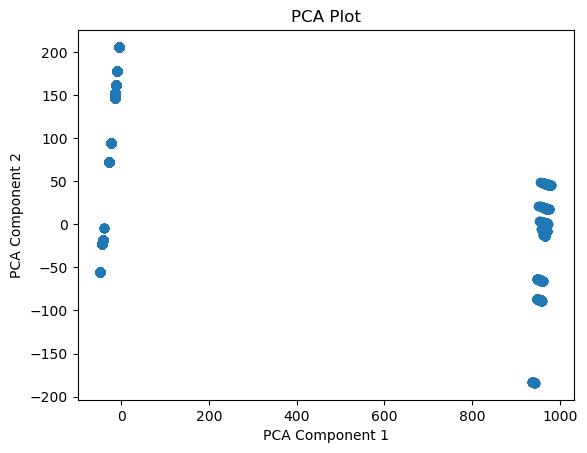

In [6]:
# Step 3: Analyze Data
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_transformed))
plt.scatter(df_pca[0], df_pca[1])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Plot')
plt.show()

In [7]:
print(df_transformed.dtypes)

one_hot_encoder__job_admin.          float64
one_hot_encoder__job_blue-collar     float64
one_hot_encoder__job_entrepreneur    float64
one_hot_encoder__job_housemaid       float64
one_hot_encoder__job_management      float64
                                      ...   
emp.var.rate                         float64
cons.price.idx                       float64
cons.conf.idx                        float64
euribor3m                            float64
nr.employed                          float64
Length: 68, dtype: object


The following step Instantiate a KMeans object with n_clusters set to the desired number of clusters.

Fit the KMeans object to the transformed data (i.e., the output of PCA in step 3).

Predict the cluster labels for each sample in the transformed data.

Add the cluster labels as a new column to the original DataFrame df, so that each row is now labeled with its corresponding cluster.

More specifically, KMeans is an unsupervised machine learning algorithm used for clustering. The n_clusters parameter specifies the number of clusters to form. The fit method is used to fit the algorithm to the data, and the predict method is used to assign cluster labels to each data point. The resulting cluster labels are then added to the original DataFrame df.

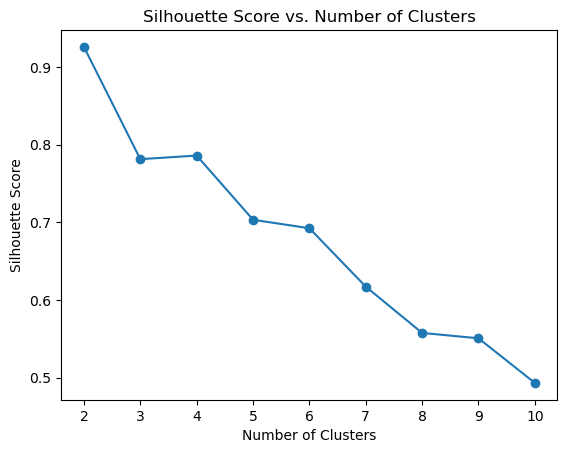

In [15]:
# Step 4: Segment Customers
pipeline = Pipeline([
    ('kmeans', KMeans(random_state=42))
])

clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
scores = []
for cluster in clusters:
    pipeline.set_params(kmeans__n_clusters=cluster)
    pipeline.fit(df_transformed)
    score = silhouette_score(df_transformed, pipeline.named_steps['kmeans'].labels_)
    scores.append(score)
    
plt.plot(clusters, scores, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [16]:
# Choose the optimal number of clusters based on the plot above
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_transformed['cluster'] = kmeans.fit_predict(df_transformed)


ValueError: num must be 1 <= num <= 6, not 7

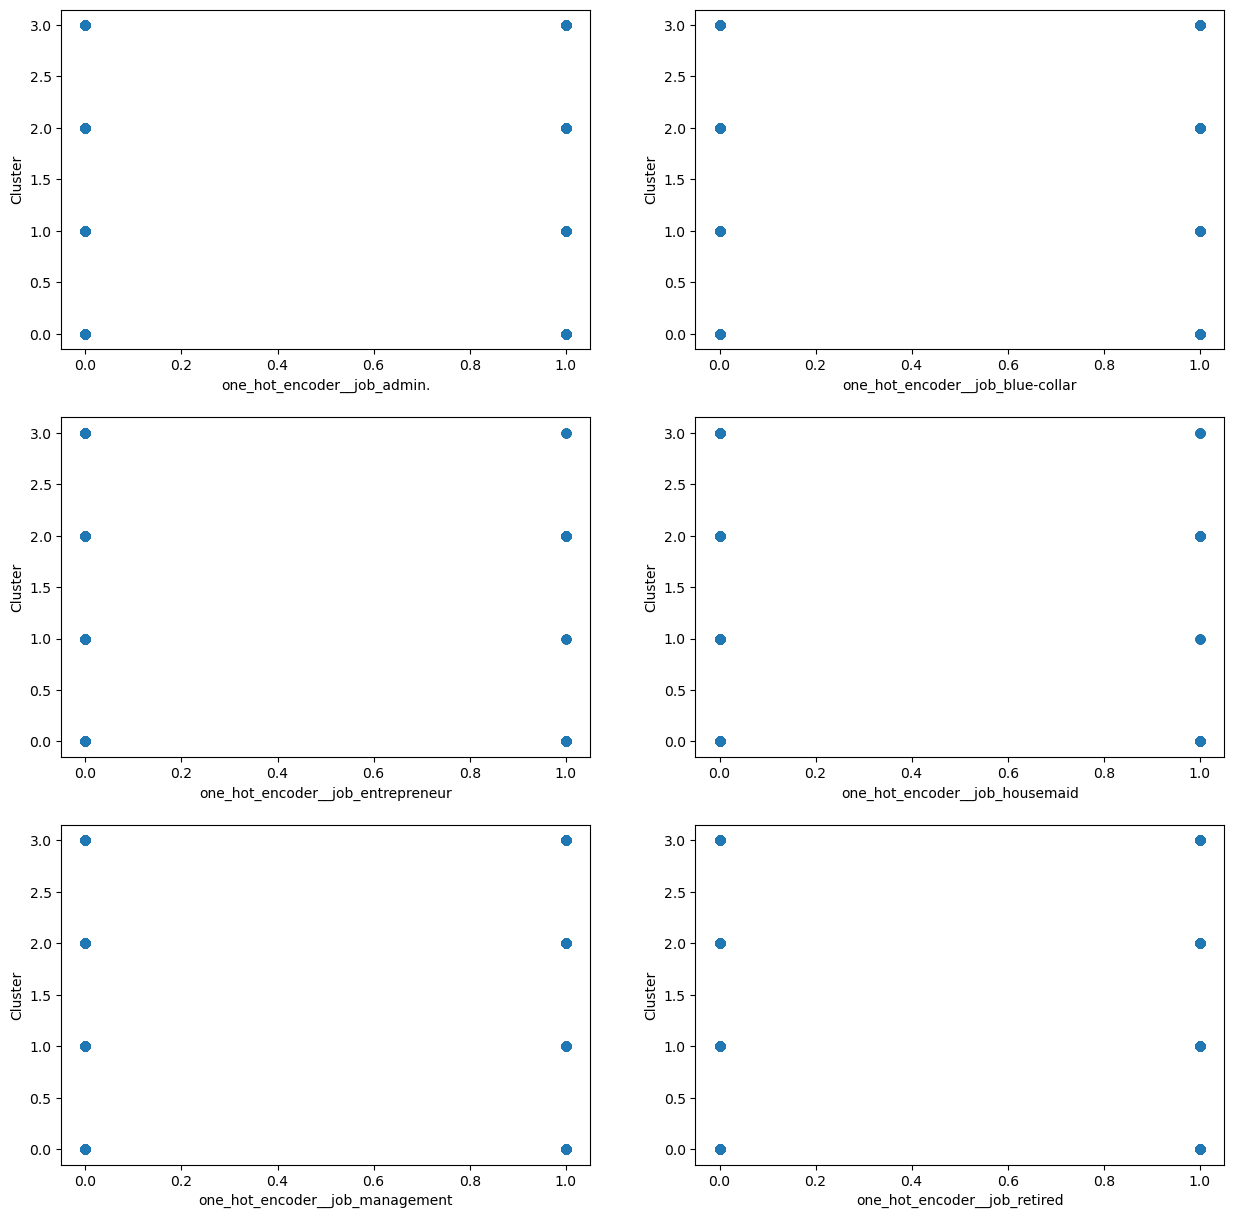

In [27]:
# Step 5: Evaluate and Refine the Model
df_transformed.groupby(['cluster']).mean()

# Visualize the clusters
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
for i, col in enumerate(df_transformed.columns[:-1]):
    if col == 'cluster':
        continue
    plt.subplot(4, 3, i+1)
    plt.scatter(df_transformed[col], df_transformed['cluster'])
    plt.xlabel(col)

    plt.ylabel('Cluster')
plt.show()